In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import torch.nn as nn
import os
import glob
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import torch.nn.functional as F
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Open the image using PIL
image = Image.open("/kaggle/input/dataset/augmented_Train/val/high/267.png")

# Convert the PIL image to a PyTorch tensor
tensor_image = torch.tensor(np.array(image))

# Check the shape of the tensor
print("Tensor shape:", tensor_image.size())


Tensor shape: torch.Size([400, 600, 3])


# Train-validation Splitting

## Enabling our GPU

In [3]:
## kar dena enable

In [4]:
# SCPA Block
class SCPA(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(SCPA,self).__init__()
        self.conv1_branch1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2_branch1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.conv1_branch2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2_branch2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv3_branch2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv4_branch2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.final_conv =    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    def forward(self,x):
        # branch 1
        branch1 = self.conv1_branch1(x)
        branch1 = self.conv2_branch1(branch1)
        # branch 2
        branch2 = self.conv1_branch2(x)
        branch2a = self.conv2_branch2(branch2)
        branch2a = self.sigmoid(branch2a)
        branch2b = self.conv3_branch2(branch2)
        branch2 = branch2a*branch2b
        branch2 = self.conv4_branch2(branch2)
        
        #combining branch 1 and branch 2
        output = branch2 + branch1
        
        #final convolutional layer and add it to the orignal input
        final_conv = self.final_conv(output)
        SCPA_output = final_conv + x
        return SCPA_output


In [5]:
# CoordConv Bloack
class CoordConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CoordConv, self).__init__()
        self.conv = nn.Conv2d(in_channels+2, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        batch_size, _, height, width = x.size()
        xx = torch.arange(width).repeat(height, 1)
        yy = torch.arange(height).view(-1, 1).repeat(1, width)
        xx = xx.float() / (width - 1)
        yy = yy.float() / (height - 1)
        xx = xx.repeat(batch_size, 1, 1).unsqueeze(1)
        yy = yy.repeat(batch_size, 1, 1).unsqueeze(1)
        if x.is_cuda:
            xx = xx.cuda()
            yy = yy.cuda()
        # adding x and y cordinate to RGB channel
        x = torch.cat([x, xx, yy], dim=1)
        x = self.conv(x)
        return x


In [6]:
class InvResBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(InvResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        
        out = self.relu(out) 
        
        return out



In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Calculate attention weights
        att_weights = self.conv1(x)
        att_weights = self.sigmoid(att_weights)
        # Apply attention to input features
        x_att = x * att_weights
        return x_att



In [8]:
def double_conv(in_c,out_c):
    conv = nn.Sequential(
    nn.Conv2d(in_c,out_c,kernel_size=3,padding =1), # padding is added on my own
    nn.ReLU(inplace=True),
    nn.Conv2d(out_c,out_c,kernel_size=3,padding =1 ),
    nn.ReLU(inplace=True)
    )
    return conv
def crop_img(tensor, target_tensor):
    _, _, h, w = target_tensor.size()
    return tensor[:, :, :h, :w]


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)
        self.out = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1)
    
    def forward(self, image):
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)  # skip
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)  # skip
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)  # skip
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)  # skip
        x9 = self.down_conv_5(x8)
        
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x = self.out(x)
        return x


In [9]:
# Denoising branch
'''
convolutional block -> 4 inv residual block -> attention block -> convolution block 
'''
class DenoiseBranch(nn.Module):
    def __init__(self,in_channel=3,out_channel=3):
        super(DenoiseBranch,self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_channel,out_channels =256,kernel_size = 3,padding =1)
        self.inv_1 = InvResBlock(in_channels=256, mid_channels=128, out_channels=256)
        self.inv_2 = InvResBlock(in_channels=256, mid_channels=128, out_channels=256)
        self.inv_3 = InvResBlock(in_channels=256, mid_channels=128, out_channels=256)
        self.inv_4 = InvResBlock(in_channels=256, mid_channels=128, out_channels=256)
        self.attention = AttentionBlock(in_channels = 256)
        self.conv_2 = nn.Conv2d(in_channels=256,out_channels = 3,kernel_size = 3,padding =1)
    
    def forward(self,x):
        x = self.conv_1(x)
        x = self.inv_1(x)
        x = self.inv_2(x)
        x = self.inv_3(x)
        x = self.inv_4(x)
        x = self.attention(x)
        x = self.conv_2(x)
        return x


In [10]:
class SCPA_Branch(nn.Module):
    def __init__(self,in_channel=3,out_channel=3):
        super(SCPA_Branch,self).__init__()
        self.coord_layer = CoordConv(in_channels =3,out_channels = 5)
        self.SCPA_1 = SCPA(in_channels = 5, out_channels =5)
        self.SCPA_2 = SCPA(in_channels = 5, out_channels =5)
        self.SCPA_3 = SCPA(in_channels = 5, out_channels =5)
        self.SCPA_4 = SCPA(in_channels = 5, out_channels =5)
        self.SCPA_5 = SCPA(in_channels = 5, out_channels =5)
        self.conv_layer =nn.Conv2d(in_channels=5,out_channels =3,kernel_size = 3,padding =1)
        
    def forward(self,x):
        x = self.coord_layer(x)
        x = self.SCPA_1(x)
        x = self.SCPA_2(x)
        x = self.SCPA_3(x)
        x = self.SCPA_4(x)
        x = self.SCPA_5(x)
        x = self.conv_layer(x)
        return x 

In [11]:
class LowLightModel(nn.Module):
    def __init__(self,in_channel=3,out_channel=3):
        super(LowLightModel,self).__init__()
        self.SCPA_branch = SCPA_Branch(in_channel=3,out_channel=3)
        self.Denoiser = DenoiseBranch(in_channel=3,out_channel=3)
        self.Unet = Unet()
        self.Conv = nn.Conv2d(in_channels=3,out_channels =3,kernel_size = 3,padding =1)
        
    def forward(self,x):
        # denoiser branch
        denoised = self.Denoiser(x)
        
        #SCPA branch 
        SCPA = self.SCPA_branch(x)
        Unet_input = SCPA + x
        Unet_output = self.Unet(Unet_input)
        # padding
        diff = Unet_input.size(3) - Unet_output.size(3)
        pad_left = diff // 2
        pad_right = diff - pad_left

        # Pad Unet_output
        Unet_output = F.pad(Unet_output, (pad_left, pad_right, 0, 0))
        
        output = self.Conv(Unet_output)
        final_output = output + denoised
        return final_output

In [12]:
class LowLightDataset(Dataset):
    def __init__(self, low_img_dir, high_img_dir, transform=None):
        self.low_img_dir = low_img_dir
        self.high_img_dir = high_img_dir
        self.low_images = sorted(os.listdir(low_img_dir))
        self.high_images = sorted(os.listdir(high_img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_img_dir, self.low_images[idx])
        high_img_path = os.path.join(self.high_img_dir, self.high_images[idx])
        low_image = Image.open(low_img_path).convert("RGB")
        high_image = Image.open(high_img_path).convert("RGB")

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [13]:
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    pixel_max = 1.0
    return 20 * torch.log10(pixel_max / torch.sqrt(mse))

In [14]:
import torch.optim as optim

# Dataset paths
train_low_dir = '/kaggle/input/dataset/augmented_Train/augmented/low/'
train_high_dir = '/kaggle/input/dataset/augmented_Train/augmented/high/'
val_low_dir = '/kaggle/input/dataset/augmented_Train/val/low/'
val_high_dir = '/kaggle/input/dataset/augmented_Train/val/high/'

In [15]:
# Create datasets and dataloaders
train_dataset = LowLightDataset(train_low_dir, train_high_dir, transform=transform)
val_dataset = LowLightDataset(val_low_dir, val_high_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [16]:
def gaussian(window_size, sigma):
    gauss = torch.tensor([torch.exp(torch.tensor(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2))) for x in range(window_size)], dtype=torch.float32)
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean() if size_average else ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - ssim(img1, img2, self.window_size, self.size_average)

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.ssim_loss = SSIMLoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, output, target):
        # L1 loss
        l1_loss = self.l1_loss(output, target)
        
        # SSIM loss
        ssim_loss = self.ssim_loss(output, target)
        
        # Gradient loss
        grad_loss = self.gradient_loss(output, target)
        
        # Combined loss
        total_loss = 0.1 * ssim_loss + l1_loss + grad_loss
        
        return total_loss

    def gradient_loss(self, output, target):
        # Compute gradients
        output_grad_x = torch.abs(output[:, :, :, :-1] - output[:, :, :, 1:])
        output_grad_y = torch.abs(output[:, :, :-1, :] - output[:, :, 1:, :])
        target_grad_x = torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])
        target_grad_y = torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :])
        
        # Compute gradient loss
        grad_loss_x = F.l1_loss(output_grad_x, target_grad_x)
        grad_loss_y = F.l1_loss(output_grad_y, target_grad_y)
        
        return grad_loss_x + grad_loss_y


In [31]:
# Initialize the model, loss function, and optimizer
model = LowLightModel()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = CombinedLoss()
model.load_state_dict(torch.load('/kaggle/input/75-epochs/model_75epochs.pth'))

<All keys matched successfully>

In [23]:
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for low_img, high_img in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Training", leave=False):
        low_img, high_img = low_img.to(device), high_img.to(device)
        
        # Forward pass
        output = model(low_img)
        
        # Compute loss
        loss = criterion(output, high_img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_psnr = 0.0
    with torch.no_grad():
        for low_img, high_img in val_loader:
            low_img, high_img = low_img.to(device), high_img.to(device)
            output = model(low_img)
            val_psnr += psnr(output, high_img).item()
    
    train_loss /= len(train_loader)
    val_psnr /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, PSNR: {val_psnr:.2f} dB")


Epoch [1/5], Loss: 0.0347, PSNR: 16.43 dB
Epoch [2/5], Loss: 0.0218, PSNR: 17.03 dB
Epoch [3/5], Loss: 0.0205, PSNR: 16.60 dB
Epoch [4/5], Loss: 0.0195, PSNR: 16.81 dB
Epoch [5/5], Loss: 0.0198, PSNR: 17.04 dB


In [21]:
new_epochs = 15  # New number of epochs to run
start_epoch = 40
total_epochs = start_epoch + new_epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(start_epoch, total_epochs):
    model.train()
    train_loss = 0.0
    for low_img, high_img in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Training", leave=False):
        low_img, high_img = low_img.to(device), high_img.to(device)
        
        # Forward pass
        output = model(low_img)
        
        # Compute loss
        loss = criterion(output, high_img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_psnr = 0.0
    with torch.no_grad():
        for low_img, high_img in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Validation", leave=False):
            low_img, high_img = low_img.to(device), high_img.to(device)
            output = model(low_img)
            val_psnr += psnr(output, high_img).item()
    
    train_loss /= len(train_loader)
    val_psnr /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {train_loss:.4f}, PSNR: {val_psnr:.2f} dB")

torch.save(model.state_dict(), 'model_55epochs.pth')

Epoch [41/55], Loss: 0.1309, PSNR: 17.28 dB


Epoch [42/55], Loss: 0.1312, PSNR: 16.49 dB


Epoch [43/55], Loss: 0.1315, PSNR: 17.61 dB


Epoch [44/55], Loss: 0.1284, PSNR: 17.63 dB


Epoch [45/55], Loss: 0.1296, PSNR: 17.78 dB


Epoch [46/55], Loss: 0.1290, PSNR: 17.62 dB


Epoch [47/55], Loss: 0.1283, PSNR: 16.61 dB


Epoch [48/55], Loss: 0.1299, PSNR: 17.27 dB


Epoch [49/55], Loss: 0.1281, PSNR: 17.70 dB


Epoch [50/55], Loss: 0.1296, PSNR: 17.83 dB


Epoch [51/55], Loss: 0.1295, PSNR: 17.63 dB


Epoch [52/55], Loss: 0.1283, PSNR: 15.95 dB


Epoch [53/55], Loss: 0.1297, PSNR: 17.75 dB


Epoch [54/55], Loss: 0.1285, PSNR: 17.09 dB


Epoch [55/55], Loss: 0.1286, PSNR: 17.39 dB


In [24]:
new_epochs = 15 # New number of epochs to run
start_epoch = 55
total_epochs = start_epoch + new_epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(start_epoch, total_epochs):
    model.train()
    train_loss = 0.0
    # Wrap train_loader with tqdm
    for low_img, high_img in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Training", leave=False):
        low_img, high_img = low_img.to(device), high_img.to(device)
        
        # Forward pass
        output = model(low_img)
        
        # Compute loss
        loss = criterion(output, high_img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_psnr = 0.0
    # Wrap val_loader with tqdm
    with torch.no_grad():
        for low_img, high_img in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Validation", leave=False):
            low_img, high_img = low_img.to(device), high_img.to(device)
            output = model(low_img)
            val_psnr += psnr(output, high_img).item()
    
    train_loss /= len(train_loader)
    val_psnr /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {train_loss:.4f}, PSNR: {val_psnr:.2f} dB")

# Save the state after additional training
torch.save(model.state_dict(), 'model_70epochs.pth')

Epoch [56/70], Loss: 0.1226, PSNR: 16.36 dB


Epoch [57/70], Loss: 0.1232, PSNR: 17.49 dB


Epoch [58/70], Loss: 0.1216, PSNR: 17.37 dB


Epoch [59/70], Loss: 0.1241, PSNR: 16.95 dB


Epoch [60/70], Loss: 0.1219, PSNR: 16.80 dB


Epoch [61/70], Loss: 0.1236, PSNR: 17.50 dB


Epoch [62/70], Loss: 0.1233, PSNR: 17.58 dB


Epoch [63/70], Loss: 0.1228, PSNR: 17.10 dB


Epoch [64/70], Loss: 0.1218, PSNR: 17.52 dB


Epoch [65/70], Loss: 0.1212, PSNR: 16.86 dB


Epoch [66/70], Loss: 0.1229, PSNR: 17.62 dB


Epoch [67/70], Loss: 0.1200, PSNR: 17.82 dB


Epoch [68/70], Loss: 0.1212, PSNR: 17.90 dB


Epoch [69/70], Loss: 0.1201, PSNR: 17.78 dB


Epoch [70/70], Loss: 0.1198, PSNR: 17.19 dB


In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.0004)
new_epochs = 5 # New number of epochs to run
start_epoch = 70
total_epochs = start_epoch + new_epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(start_epoch, total_epochs):
    model.train()
    train_loss = 0.0
    # Wrap train_loader with tqdm
    for low_img, high_img in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Training", leave=False):
        low_img, high_img = low_img.to(device), high_img.to(device)
        
        # Forward pass
        output = model(low_img)
        
        # Compute loss
        loss = criterion(output, high_img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_psnr = 0.0
    # Wrap val_loader with tqdm
    with torch.no_grad():
        for low_img, high_img in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Validation", leave=False):
            low_img, high_img = low_img.to(device), high_img.to(device)
            output = model(low_img)
            val_psnr += psnr(output, high_img).item()
    
    train_loss /= len(train_loader)
    val_psnr /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {train_loss:.4f}, PSNR: {val_psnr:.2f} dB")

# Save the state after additional training
torch.save(model.state_dict(), 'model_75epochs.pth')

Epoch [71/75], Loss: 0.1204, PSNR: 17.34 dB


Epoch [72/75], Loss: 0.1176, PSNR: 17.50 dB


Epoch [73/75], Loss: 0.1192, PSNR: 17.37 dB


Epoch [74/75], Loss: 0.1190, PSNR: 17.33 dB


Epoch [75/75], Loss: 0.1190, PSNR: 17.72 dB


In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.00002)
new_epochs = 5 # New number of epochs to run
start_epoch = 100
total_epochs = start_epoch + new_epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(start_epoch, total_epochs):
    model.train()
    train_loss = 0.0
    # Wrap train_loader with tqdm
    for low_img, high_img in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Training", leave=False):
        low_img, high_img = low_img.to(device), high_img.to(device)
        
        # Forward pass
        output = model(low_img)
        
        # Compute loss
        loss = criterion(output, high_img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_psnr = 0.0
    # Wrap val_loader with tqdm
    with torch.no_grad():
        for low_img, high_img in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{total_epochs}] Validation", leave=False):
            low_img, high_img = low_img.to(device), high_img.to(device)
            output = model(low_img)
            val_psnr += psnr(output, high_img).item()
    
    train_loss /= len(train_loader)
    val_psnr /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {train_loss:.4f}, PSNR: {val_psnr:.2f} dB")

# Save the state after additional training
torch.save(model.state_dict(), 'model_100epochs.pth')

Epoch [101/105], Loss: 0.1114, PSNR: 17.17 dB


KeyboardInterrupt: 

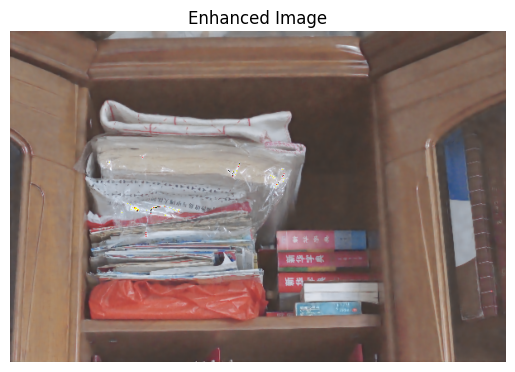

In [44]:
model.eval()
transform = transforms.Compose([
    transforms.Resize((400, 600)),
    transforms.ToTensor() 
])

input_image_path = '/kaggle/input/dataset/augmented_Train/val/low/267.png'
input_image = Image.open(input_image_path).convert('RGB')
input_tensor = transform(input_image).unsqueeze(0)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    enhanced_tensor = model(input_tensor)

    enhanced_tensor = enhanced_tensor.cpu()
enhanced_image = transforms.ToPILImage()(enhanced_tensor.squeeze())
plt.imshow(enhanced_image)
plt.title('Enhanced Image')
plt.axis('off')
plt.show()

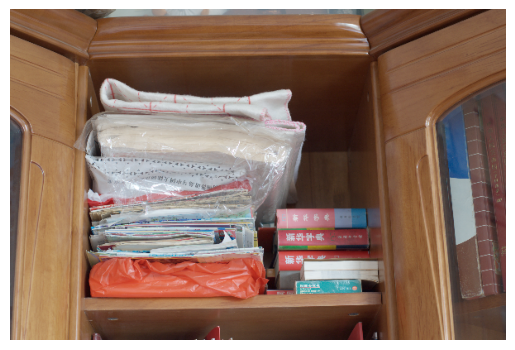

In [45]:
image = cv2.imread("/kaggle/input/dataset/augmented_Train/val/high/267.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off') 
plt.show()

In [43]:
torch.save(model.state_dict(), 'model_100epoch.pth')